In [8]:
# analyze_scaling.py
import numpy as np
import matplotlib.pyplot as plt


In [9]:
workers = [1, 2, 4, 6, 8, 10, 12] # List of P values tested
runtimes = [217.91, 117.701, 77.702, 59.506, 46.000, 49.436, 38.967] # Corresponding runtimes in seconds
# --- Constants ---
NUM_FLOORPLANS_TIMED = 20 # Number of floorplans used for the timing runs (e.g., 100)
TOTAL_FLOORPLANS = 4571   # Total number of floorplans in the full dataset
# --- ----------- ---

--- Scaling Analysis ---
Data used for N = 20 floorplans.
Serial Runtime (P=1): 217.91 s
--------------------
b) Amdahl's Law Estimation:
   Estimated Parallel Fraction (f): 0.8958 (89.6%)
--------------------
c) Maximum Speedup:
   Max Achieved Speedup: 5.59x (at P=12 workers)
   Theoretical Max Speedup (based on estimated f): 9.60x
--------------------
d) Full Dataset Runtime Estimation:
   Fastest Measured Runtime (20 plans): 38.97 s (at P=12 workers)
   Estimated Total Runtime (4571 plans): 8905.91 s (2.47 hours)
--------------------


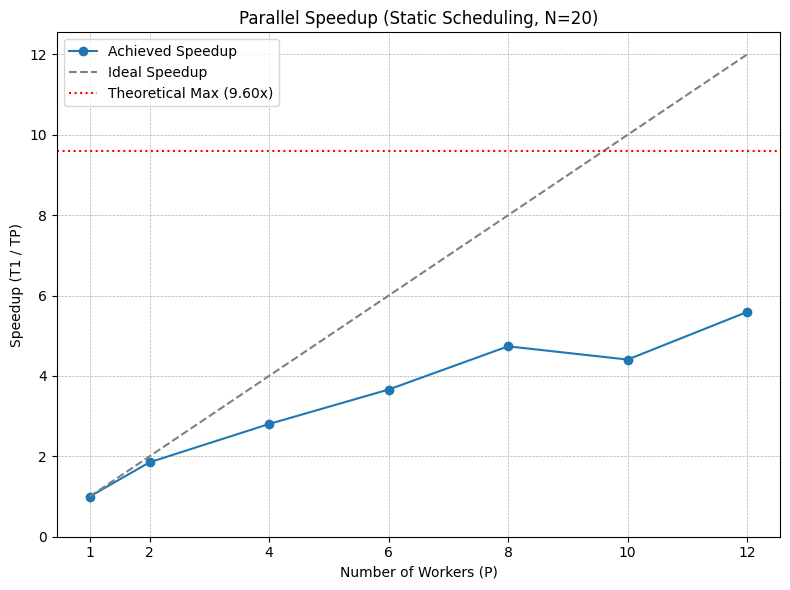

In [10]:

workers = [1, 2, 4, 6, 8, 10, 12] # List of P values tested
runtimes = [217.91, 117.701, 77.702, 59.506, 46.000, 49.436, 38.967] # Corresponding runtimes in seconds

# --- Constants ---
NUM_FLOORPLANS_TIMED = 20 # Number of floorplans used for the timing runs (e.g., 100)
TOTAL_FLOORPLANS = 4571   # Total number of floorplans in the full dataset
# --- ----------- ---

# Convert to numpy arrays for easier calculations
p = np.array(workers)
t = np.array(runtimes)

if len(p) != len(t):
    print("Error: Workers and Runtimes lists must have the same length.")
    exit()

if 1 not in p:
    print("Error: Runtime for P=1 (serial execution) is required for speedup calculation.")
    exit()

# --- Calculations ---

# 1. Speedup
t1 = t[p == 1][0] # Get runtime for P=1 (serial time)
speedups = t1 / t

# 2. Max Achieved Speedup
max_achieved_speedup = np.max(speedups)
p_max_achieved = p[np.argmax(speedups)]

# 3. Estimate Parallel Fraction (f) using Amdahl's Law
if p_max_achieved > 1 and max_achieved_speedup > 1:
    f_estimated = (1.0 - 1.0 / max_achieved_speedup) / (1.0 - 1.0 / p_max_achieved)
    # Clamp f between 0 and 1, as estimations can sometimes go slightly outside
    f_estimated = max(0.0, min(1.0, f_estimated))
else:
    f_estimated = 0.0 # Assume no parallelization if P=1 is best or speedup <= 1

# 4. Theoretical Max Speedup
if f_estimated < 1.0:
    theoretical_max_speedup = 1.0 / (1.0 - f_estimated)
else:
    theoretical_max_speedup = float('inf') # Infinite speedup if f=1

# 5. Estimate Total Runtime with Fastest Parallel Solution
fastest_runtime = np.min(t)
p_fastest = p[np.argmin(t)]
avg_time_fastest = fastest_runtime / NUM_FLOORPLANS_TIMED
estimated_total_time_s = avg_time_fastest * TOTAL_FLOORPLANS
estimated_total_time_h = estimated_total_time_s / 3600.0

# --- Output Results ---

print("--- Scaling Analysis ---")
print(f"Data used for N = {NUM_FLOORPLANS_TIMED} floorplans.")
print(f"Serial Runtime (P=1): {t1:.2f} s")
print("-" * 20)
print("b) Amdahl's Law Estimation:")
print(f"   Estimated Parallel Fraction (f): {f_estimated:.4f} ({f_estimated*100:.1f}%)")
print("-" * 20)
print("c) Maximum Speedup:")
print(f"   Max Achieved Speedup: {max_achieved_speedup:.2f}x (at P={p_max_achieved} workers)")
print(f"   Theoretical Max Speedup (based on estimated f): {theoretical_max_speedup:.2f}x" if theoretical_max_speedup != float('inf') else "   Theoretical Max Speedup (based on estimated f): Infinite")
print("-" * 20)
print("d) Full Dataset Runtime Estimation:")
print(f"   Fastest Measured Runtime ({NUM_FLOORPLANS_TIMED} plans): {fastest_runtime:.2f} s (at P={p_fastest} workers)")
print(f"   Estimated Total Runtime ({TOTAL_FLOORPLANS} plans): {estimated_total_time_s:.2f} s ({estimated_total_time_h:.2f} hours)")
print("-" * 20)


# --- Plotting ---
plt.figure(figsize=(8, 6))
plt.plot(p, speedups, marker='o', linestyle='-', label='Achieved Speedup')
plt.plot(p, p, linestyle='--', color='gray', label='Ideal Speedup') # Ideal linear speedup line

# Plot theoretical max speedup only if it's finite and meaningful
if theoretical_max_speedup != float('inf') and f_estimated > 0:
     plt.axhline(y=theoretical_max_speedup, color='red', linestyle=':', label=f'Theoretical Max ({theoretical_max_speedup:.2f}x)')

plt.title(f'Parallel Speedup (Static Scheduling, N={NUM_FLOORPLANS_TIMED})')
plt.xlabel('Number of Workers (P)')
plt.ylabel('Speedup (T1 / TP)')
plt.xticks(p) # Show ticks for actual worker counts tested
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.ylim(bottom=0) # Start y-axis at 0
plt.tight_layout()
plt.savefig("parallel_scaling")
plt.show()